In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Model Monitoring for Vertex AI Custom Model Online Prediction

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring_v2/model_monitoring_for_custom_model_online_prediction.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2model_monitoring_v2%2model_monitoring_for_custom_model_online_prediction.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring_v2/model_monitoring_for_custom_model_online_prediction.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring_v2/model_monitoring_for_custom_model_online_prediction.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


## Overview

This tutorial demonstrates how to use the Vertex AI SDK for Python to set up Vertex AI Model Monitoring V2 for your model.

### Objective

In this tutorial, you'll complete the following steps:

- Upload a custom model to Vertex AI Model Registry.
- Deploy the model to Vertex AI Endpoint with Request-Response Logging enabled.
- Generate some online prediction traffic.
- Create a model monitor.
- Run an on-demand model monitoring job to analyze data drift between the Online prediction traffic and the training dataset.
- Run an on-demand model monitoring job to analyze feature attribution drift between the Online prediction traffic and a GCS baseline dataset.
- Create a schedule to continuously run model monitoring jobs to analyze data drift between the Online prediction traffic and the training dataset.


### Costs

Vertex AI Model Monitoring v2 is free during the public preview period, but you will still be billed for the following Google Cloud services:

* [BigQuery](https://cloud.google.com/bigquery/pricing)
* [Cloud Storage](https://cloud.google.com/storage/pricing)
* [Vertex AI Online Prediction](https://cloud.google.com/vertex-ai/pricing#prediction-prices)
* [Vertex AI Batch Explanation Job](https://cloud.google.com/vertex-ai/pricing#prediction-prices) (if you run the feature attribution drift example).

In [1]:
# @title Install Vertex AI SDK and other required packages
! pip3 install --upgrade --quiet  google-cloud-aiplatform \
                                  google-cloud-bigquery \
                                  # pandas \
                                  # pandas_gbq \
                                  # pyarrow \
                                  # tensorflow_data_validation[visualization] \


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 7.8 MB/s eta 0:00:00


In [2]:
# @title Check aiplatform version
from google.cloud import aiplatform
aiplatform.__version__

'1.76.0'

In [5]:
# @title Define constants

PROJECT_ID="ai-hangsik" # @param {type:"string"}
LOCATION="us-central1" # @param {type:"string"}

In [11]:
# @title GCP Authentication

# Use OAuth to access the GCP environment.
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user(project_id=PROJECT_ID)

In [19]:
# @title Initialize Vertex AI SDK for Python

import os
import vertexai

! gcloud config set project $PROJECT_ID
# os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
! gcloud config set ai/region $LOCATION

vertexai.init(project=PROJECT_ID, location=LOCATION)

Updated property [core/project].
Updated property [ai/region].


In [17]:
# @title Create a Cloud Storage bucket
BUCKET_URI = f"gs://sllm-0112"  # @param {type:"string"}

In [14]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://sllm-0112/...


### Step 2: Prepare a model in Vertex AI Model Registry

You can register a model in Vertex AI Model Registry with its artifacts, enabling you to perform online serving or batch prediction. Alternatively, you can register a referenced/placeholder model that includes only the model's name.
In this notebook, you register a model with artifacts because you'll run a batch prediction job.

In [21]:
# @title Prepare a model in Vertex AI Model Registry

import google.cloud.aiplatform as aiplatform

MODEL_PATH = "gs://cloud-samples-data/vertex-ai/model-deployment/models/churn"
MODEL_NAME = "churn"
IMAGE = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"

model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=MODEL_PATH,
    serving_container_image_uri=IMAGE,
    sync=True,

)

MODEL_ID = model.resource_name.split("/")[-1]

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/721521243942/locations/us-central1/models/3764574981388763136/operations/1718337559530045440
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/721521243942/locations/us-central1/models/3764574981388763136@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/721521243942/locations/us-central1/models/3764574981388763136@1')


### Step 3: Deploy Model to Vertex AI Endpoint with Request-Respponse Logging Enabled

#### Create an endpoint with logging enabled and deploy the model to this endpoint.

In [22]:
# Create an endpoint with logging enabled. Specify the logging sampling rate and BigQuery destination.
import pandas as pd

TIMESTAMP = pd.Timestamp.utcnow().strftime("%Y%m%d%H%M%S")
ENDPOINT_DISPLAY_NAME = f"churn_endpoint_{TIMESTAMP}"
BQ_LOGGING_DATASET = f"churn_production_{TIMESTAMP}"
BQ_LOGGING_TABLE = f"bq://{PROJECT_ID}.{BQ_LOGGING_DATASET}.req_resp"

endpoint = aiplatform.Endpoint.create(
    display_name=ENDPOINT_DISPLAY_NAME,
    enable_request_response_logging=True,
    request_response_logging_sampling_rate=1.0,
    request_response_logging_bq_destination_table=BQ_LOGGING_TABLE,
)

# Deploy model to this endpoint
endpoint.deploy(
    model=model,
    traffic_percentage=100,
    min_replica_count=1,
    max_replica_count=1,
    machine_type="n1-standard-4",
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/721521243942/locations/us-central1/endpoints/2095045739448107008/operations/2497460295065141248
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/721521243942/locations/us-central1/endpoints/2095045739448107008
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/721521243942/locations/us-central1/endpoints/2095045739448107008')
INFO:google.cloud.aiplatform.models:Deploying Model projects/721521243942/locations/us-central1/models/3764574981388763136 to Endpoint : projects/721521243942/locations/us-central1/endpoints/2095045739448107008
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/721521243942/locations/us-central1/endpoints/2095045739448107008/operations/14851000477155328
INFO:google.cloud.aiplatfor

#### Run a prediction test

In [62]:
DEFAULT_INPUT = {
    "cnt_ad_reward": 0,
    "cnt_challenge_a_friend": 0,
    "cnt_completed_5_levels": 2,
    "cnt_level_complete_quickplay": 3,
    "cnt_level_end_quickplay": 5,
    "cnt_level_reset_quickplay": 2,
    "cnt_level_start_quickplay": 6,
    "cnt_post_score": 34,
    "cnt_spend_virtual_currency": 2,
    "cnt_use_extra_steps": 1,
    "cnt_user_engagement": 120,
    "country": "Denmark",
    "dayofweek": 3,
    "julianday": 254,
    "language": "da-dk",
    "month": 9,
    "operating_system": "IOS",
    "user_pseudo_id": "104B0770BAE16E8B53DF330C95881893",
}

1 0.8984445752735083
0 0.1015554247264917
Prediction(predictions=[{'churned_probs': [0.8984445752735083, 0.1015554247264917], 'churned_values': ['1', '0'], 'predicted_churned': ['1']}], deployed_model_id='8185209859373793280', metadata=None, model_version_id='1', model_resource_name='projects/721521243942/locations/us-central1/models/3764574981388763136', explanations=None)


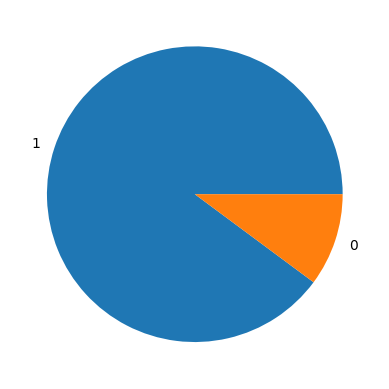

In [63]:
import pprint as pp

import matplotlib.pyplot as plt

try:
    resp = endpoint.predict([DEFAULT_INPUT])
    for i in resp.predictions:
        vals = i["churned_values"]
        probs = i["churned_probs"]
    for i in range(len(vals)):
        print(vals[i], probs[i])
    plt.pie(probs, labels=vals)
    pp.pprint(resp)
except Exception as ex:
    print("prediction request failed", ex)

#### Send some online prediction requests to the endpoint

In [52]:
import sys
import time

from google.cloud import bigquery

# Here we just use subset of the training dataset as prediction data
DATASET_BQ_URI = "bq://ai-hangsik.bqmlga4.churn"
GROUND_TRUTH = "churned"

bqclient = bigquery.Client(project=PROJECT_ID)
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])
print(table)
rows = bqclient.list_rows(table, max_results=1000)

count = 0

for row in rows:
    instance = {}
    for key, value in row.items():
        if key == GROUND_TRUTH:
            continue
        if value is None:
            value = ""

        if key == "user_first_engagement":
            continue

        instance[key] = value
        #print(f"k:{key}, value:{value}")

    endpoint.predict(instances=[instance])

    # Print progress
    if count % 100 == 0:
        print(f"Sent: {count} requests")
    count = count + 1
    time.sleep(0.01)

ai-hangsik.bqmlga4.churn
Sent: 0 requests


INFO:vertexai.resources.preview.ml_monitoring.model_monitors:ModelMonitoringJob run completed. Resource name: projects/721521243942/locations/us-central1/modelMonitors/5138404864690225152/modelMonitoringJobs/3056932596287012864


Sent: 100 requests
Sent: 200 requests
Sent: 300 requests
Sent: 400 requests
Sent: 500 requests
Sent: 600 requests
Sent: 700 requests
Sent: 800 requests
Sent: 900 requests


#### Check the endpoint logging table.

In [38]:
import pandas as pd

query_string = (
    f"SELECT * FROM `{BQ_LOGGING_TABLE[5:]}` ORDER BY logging_time DESC LIMIT 10"
)
pd.read_gbq(query_string, project_id=PROJECT_ID)

<ipython-input-38-1580250a0c58>:6: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  pd.read_gbq(query_string, project_id=PROJECT_ID)


,endpoint,deployed_model_id,logging_time,request_id,request_payload,response_payload
0,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.526454+00:00,8919780152003568621.000000000,"[{""cnt_level_end_quickplay"":0,""cnt_ad_reward"":...","[{""churned_probs"":[0.053247060996821659,0.9467..."
1,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.453488+00:00,5530869912437452427.000000000,"[{""cnt_user_engagement"":1,""cnt_level_complete_...","[{""churned_probs"":[0.052456920574967057,0.9475..."
2,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.399023+00:00,4089497076712902740.000000000,"[{""julianday"":169,""dayofweek"":2,""cnt_spend_vir...","[{""churned_probs"":[0.052100823789414982,0.9478..."
3,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.338373+00:00,2791439195245246202.000000000,"[{""cnt_ad_reward"":0,""country"":""Kuwait"",""operat...","[{""churned_probs"":[0.098517714955776145,0.9014..."
4,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.278272+00:00,7255648676745518917.000000000,"[{""cnt_completed_5_levels"":0,""operating_system...","[{""churned_probs"":[0.055687821438779123,0.9443..."
5,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.220902+00:00,7697289376397625879.000000000,"[{""cnt_level_start_quickplay"":0,""cnt_post_scor...","[{""churned_probs"":[0.037481016178889819,0.9625..."
6,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.163404+00:00,8347831074688857607.000000000,"[{""user_pseudo_id"":""0FE7AA892150DE7C58D1B29885...","[{""churned_probs"":[0.0458657132984871,0.954134..."
7,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.099923+00:00,7201604227615770781.000000000,"[{""cnt_level_reset_quickplay"":0,""month"":6,""jul...","[{""churned_probs"":[0.0527521200274244,0.947247..."
8,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:43.036514+00:00,4768220793213819847.000000000,"[{""cnt_level_start_quickplay"":0,""country"":""Sin...","[{""churned_probs"":[0.70666326011076064,0.29333..."
9,projects/721521243942/locations/us-central1/en...,8185209859373793280,2025-01-14 11:36:42.982755+00:00,6700510311694516767.000000000,"[{""cnt_ad_reward"":0,""cnt_level_complete_quickp...","[{""churned_probs"":[0.052129343253992787,0.9478..."


### Step 4: Create a Model Monitor

#### Define Model Monitoring Schema

The monitoring schema is a required configuration for a model monitor. The schema consists of input features names, prediction outputs, and ground truth (if available), along with their respective data types.

**Note: The schema is optional only for AutoML tables (Regression/Classification), as it will be automatically fetched when available (if Model Monitoring is unable to retrieve the schema, you will need to provide your own).**

In [39]:
from vertexai.resources.preview import ml_monitoring

MODEL_MONITORING_SCHEMA = ml_monitoring.spec.ModelMonitoringSchema(
    feature_fields=[
        ml_monitoring.spec.FieldSchema(name="user_pseudo_id", data_type="string"),
        ml_monitoring.spec.FieldSchema(name="country", data_type="string"),
        ml_monitoring.spec.FieldSchema(name="operating_system", data_type="string"),
        ml_monitoring.spec.FieldSchema(name="cnt_user_engagement", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_level_start_quickplay", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_level_end_quickplay", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_level_complete_quickplay", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_level_reset_quickplay", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_post_score", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_spend_virtual_currency", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_ad_reward", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_challenge_a_friend", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_completed_5_levels", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="cnt_use_extra_steps", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="month", data_type="categorical"),
        ml_monitoring.spec.FieldSchema(name="julianday", data_type="integer"),
        ml_monitoring.spec.FieldSchema(name="dayofweek", data_type="integer"),
    ],
    ground_truth_fields=[
        ml_monitoring.spec.FieldSchema(name="churned", data_type="categorical")
    ],
    prediction_fields=[
        ml_monitoring.spec.FieldSchema(
            name="predicted_churned", data_type="categorical"
        )
    ],
)

#### (Optional) Define training dataset

The training dataset can serve as the baseline dataset to analysis the data drift in production. You can register the training dataset in the model monitor.

In [40]:
from vertexai.resources.preview import ml_monitoring

# Copy files to your projects gs bucket to avoid permission issues.
# Ignore any error(s) for bucket already exists.
PUBLIC_TRAINING_DATASET = (
    "gs://cloud-samples-data/vertex-ai/model-monitoring/churn/churn_training.csv"
)
TRAINING_URI = f"{BUCKET_URI}/model-monitoring/churn/churn_training.csv"

! gsutil copy $PUBLIC_TRAINING_DATASET $TRAINING_URI

TRAINING_DATASET = ml_monitoring.spec.MonitoringInput(
    gcs_uri=TRAINING_URI, data_format="csv"
)

Copying gs://cloud-samples-data/vertex-ai/model-monitoring/churn/churn_training.csv [Content-Type=text/csv]...
/ [1 files][717.9 KiB/717.9 KiB]                                                
Operation completed over 1 objects/717.9 KiB.                                    


#### Create a model monitor

A model monitor is a top-level resource to manage your metrics and model monitoring jobs.

In [41]:
from vertexai.resources.preview import ml_monitoring

my_model_monitor = ml_monitoring.ModelMonitor.create(
    project=PROJECT_ID,
    location=LOCATION,
    display_name="churn_model_monitor",
    model_name=model.resource_name,
    model_version_id="1",
    training_dataset=TRAINING_DATASET,
    model_monitoring_schema=MODEL_MONITORING_SCHEMA,
)
MODEL_MONITOR_ID = my_model_monitor.name
print(f"MODEL MONITOR {MODEL_MONITOR_ID} created.")

INFO:vertexai.resources.preview.ml_monitoring.model_monitors:Creating ModelMonitor
INFO:vertexai.resources.preview.ml_monitoring.model_monitors:Create ModelMonitor backing LRO: projects/721521243942/locations/us-central1/modelMonitors/5138404864690225152/operations/8008177389106364416
INFO:vertexai.resources.preview.ml_monitoring.model_monitors:ModelMonitor created. Resource name: projects/721521243942/locations/us-central1/modelMonitors/5138404864690225152
INFO:vertexai.resources.preview.ml_monitoring.model_monitors:To use this ModelMonitor in another session:
INFO:vertexai.resources.preview.ml_monitoring.model_monitors:model_monitor = aiplatform.ModelMonitor('projects/721521243942/locations/us-central1/modelMonitors/5138404864690225152')
INFO:vertexai.resources.preview.ml_monitoring.model_monitors:https://console.cloud.google.com/vertex-ai/model-monitoring/locations/us-central1/model-monitors/5138404864690225152?project=ai-hangsik


MODEL MONITOR 5138404864690225152 created.


### Step 5: Run an on-demand model monitoring job

#### Define the monitoring objective configs

For tabular models, Model Monitoring supports the following objectives:

*   **Input feature drift detection**

    Model Monitoring offers drift analysis for both categorical and numeric feature types, with the following supported metrics:

    *    Categorical Feature: `Jensen Shannon Divergence`, `L Infinity`
    *    Numeric Feature: `Jensen Shannon Divergence`

    You can choose to analyze only the features of interest by specifying them in the `features` fields of the `ml_monitoring.spec.DataDriftSpec` specification. If not specified, all input features in the model schema are analyzed. Additionally, you have the option to set default thresholds for categorical or numeric features, or you can specify thresholds for individual features. If the detected drift surpasses a threshold, an alert is sent through email or another notification channel.

*  **Prediction output drift detection**

    Similar to input feature drift detection, prediction output drift detection identifies data drift in the prediction outputs.

*   **Feature attribution drift detection**

    Model Monitoring leverages Vertex Explainable AI to monitor feature attributions. Explainable AI enables you to understand the relative contribution of each feature to a resulting prediction. In essence, it assesses the magnitude of each feature's influence.
    You must configure the `Explanation` specification with the feature attribution objectives configuration.


Input feature drift specification

In [42]:
from vertexai.resources.preview import ml_monitoring

FEATURE_THRESHOLDS = {
    "country": 0.003,
    "cnt_user_engagement": 0.004,
}

FEATURE_DRIFT_SPEC = ml_monitoring.spec.DataDriftSpec(
    categorical_metric_type="l_infinity",
    numeric_metric_type="jensen_shannon_divergence",
    default_categorical_alert_threshold=0.2,
    default_numeric_alert_threshold=0.3,
    feature_alert_thresholds=FEATURE_THRESHOLDS,
)

Prediction output drift specification

In [43]:
PREDICTION_OUTPUT_DRIFT_SPEC = ml_monitoring.spec.DataDriftSpec(
    categorical_metric_type="l_infinity",
    numeric_metric_type="jensen_shannon_divergence",
    default_categorical_alert_threshold=0.1,
    default_numeric_alert_threshold=0.1,
)

Feature attribution specification

In [44]:
FEATURE_ATTRIBUTION_SPEC = ml_monitoring.spec.FeatureAttributionSpec(
    default_alert_threshold=0.0003,
    feature_alert_thresholds={"cnt_ad_reward": 0.0001},
)

#### Define the alert notification and metrics output spec.

Model Monitoring supports the following notification methods:

*   Email
*   [Notification Channel](https://cloud.google.com/monitoring/support/notification-options)
*   [Cloud Logging](https://cloud.google.com/logging/docs)  

This notebook uses email as an example.

Export generated metrics to the Google Cloud Storage location that you specified or, if you don't specify a location, Vertex AI creates a default bucket to use.

In [45]:
import os

EMAIL = "hangsik@google.com"  # @param {type:"string"}
if os.getenv("IS_TESTING"):
    EMAIL = "noreply@google.com"

NOTIFICATION_SPEC = ml_monitoring.spec.NotificationSpec(
    user_emails=[EMAIL],
)

OUTPUT_SPEC = ml_monitoring.spec.OutputSpec(gcs_base_dir=BUCKET_URI)

#### Run Model Monitoring Jobs

##### **Example 1: Feature drift & Prediction output drift detection, compares current data with the training dataset.**

In [46]:
import pandas as pd

TIMESTAMP = pd.Timestamp.utcnow().strftime("%Y%m%d%H%M%S")
JOB_DISPLAY_NAME = f"churn_model_monitoring_job_{TIMESTAMP}"
TARGET_DATASET = ml_monitoring.spec.MonitoringInput(endpoints=[endpoint.resource_name])

model_monitoring_job_1 = my_model_monitor.run(
    display_name=JOB_DISPLAY_NAME,
    baseline_dataset=TRAINING_DATASET,
    target_dataset=TARGET_DATASET,
    tabular_objective_spec=ml_monitoring.spec.TabularObjective(
        # Input feature drift spec.
        feature_drift_spec=FEATURE_DRIFT_SPEC,
        # Prediction output drift spec.
        prediction_output_drift_spec=PREDICTION_OUTPUT_DRIFT_SPEC,
    ),
    notification_spec=NOTIFICATION_SPEC,
    output_spec=OUTPUT_SPEC,
)

INFO:vertexai.resources.preview.ml_monitoring.model_monitors:Creating ModelMonitoringJob


##### **Example 2: Feature attribution drift detection, compares current data with a Cloud Storage baseline dataset**

For feature attribution monitoring, the dataset is sent to the Vertex AI batch explanation job in the following way:

*   Google Cloud Storage -> Sent directly as input to Vertex AI batch explanation job.
*   BigQuery table -> Sent directly as input to Vertex AI batch explanation job.
*   BigQuery Query -> Not supported.
*   Vertex AI batch explanation job -> Input of batch prediction job is used as input for the Vertex AI batch explanation job.
*   Vertex AI endpoint logging -> Request logging is used as input for Vertex AI batch explanation job.

Check that these datasets meet the requirements for a Vertex AI batch explanation job.

###### Generate model metadata for Vertex Explainable AI
You must specify the explanation specification to use a Vertex AI batch explanation job. Run the following cell to extract metadata from the exported model, which is needed for generating the explanations for a prediction request.

In [54]:
from google.cloud.aiplatform_v1beta1.types import (ExplanationMetadata,
                                                   ExplanationParameters,
                                                   ExplanationSpec)

EXPLANATION_SPEC = ExplanationSpec(
    parameters=ExplanationParameters(
        {"sampled_shapley_attribution": {"path_count": 2}}
    ),
    metadata=ExplanationMetadata(
        inputs={
            "cnt_ad_reward": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_ad_reward",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_challenge_a_friend": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_challenge_a_friend",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_completed_5_levels": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_completed_5_levels",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_level_complete_quickplay": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_level_complete_quickplay",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_level_end_quickplay": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_level_end_quickplay",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_level_reset_quickplay": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_level_reset_quickplay",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_level_start_quickplay": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_level_start_quickplay",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_post_score": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_post_score",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_spend_virtual_currency": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_spend_virtual_currency",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_use_extra_steps": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_use_extra_steps",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "cnt_user_engagement": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "cnt_user_engagement",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "country": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "country",
                    "encoding": "IDENTITY",
                    "modality": "categorical",
                }
            ),
            "dayofweek": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "dayofweek",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "julianday": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "julianday",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "language": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "language",
                    "encoding": "IDENTITY",
                    "modality": "categorical",
                }
            ),
            "month": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "month",
                    "encoding": "IDENTITY",
                    "modality": "numeric",
                }
            ),
            "operating_system": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "operating_system",
                    "encoding": "IDENTITY",
                    "modality": "categorical",
                }
            ),
            "user_pseudo_id": ExplanationMetadata.InputMetadata(
                {
                    "input_tensor_name": "user_pseudo_id",
                    "encoding": "IDENTITY",
                    "modality": "categorical",
                }
            ),
        },
        outputs={
            "churned_probs": ExplanationMetadata.OutputMetadata(
                {"output_tensor_name": "churned_probs"}
            )
        },
    ),
)

In [55]:
FEATURE_ATTRIBUTION_BASELINE_DATASET = (
    f"{BUCKET_URI}/model-monitoring/churn/churn_no_ground_truth.jsonl"
)
! gsutil cp gs://cloud-samples-data/vertex-ai/model-monitoring/churn/churn_no_ground_truth.jsonl $FEATURE_ATTRIBUTION_BASELINE_DATASET

Copying gs://cloud-samples-data/vertex-ai/model-monitoring/churn/churn_no_ground_truth.jsonl [Content-Type=application/octet-stream]...
- [1 files][  3.5 MiB/  3.5 MiB]                                                
Operation completed over 1 objects/3.5 MiB.                                      


In [56]:
import pandas as pd
from vertexai.resources.preview import ml_monitoring

TIMESTAMP = pd.Timestamp.utcnow().strftime("%Y%m%d%H%M%S")
JOB_DISPLAY_NAME = f"churn_model_monitoring_job_{TIMESTAMP}"
BASELINE_DATASET = ml_monitoring.spec.MonitoringInput(
    gcs_uri=FEATURE_ATTRIBUTION_BASELINE_DATASET, data_format="jsonl"
)
TARGET_DATASET = ml_monitoring.spec.MonitoringInput(endpoints=[endpoint.resource_name])
model_monitoring_job_2 = my_model_monitor.run(
    display_name=JOB_DISPLAY_NAME,
    baseline_dataset=BASELINE_DATASET,
    target_dataset=TARGET_DATASET,
    tabular_objective_spec=ml_monitoring.spec.TabularObjective(
        # Feature attribution spec.
        feature_attribution_spec=FEATURE_ATTRIBUTION_SPEC
    ),
    # You must have a Explanation spec for feature attribution monitoring.
    # You can specify the explanation spec in the Model, Model monitor, or the Model monitoring job.
    explanation_spec=EXPLANATION_SPEC,
    notification_spec=NOTIFICATION_SPEC,
    output_spec=OUTPUT_SPEC,
)

INFO:vertexai.resources.preview.ml_monitoring.model_monitors:Creating ModelMonitoringJob


##### List Model Monitoring Jobs

In [58]:
my_model_monitor.list_jobs()

[name: "projects/721521243942/locations/us-central1/modelMonitors/5138404864690225152/modelMonitoringJobs/1723867106585346048"
display_name: "churn_model_monitoring_job_20250114120611"
model_monitoring_spec {
  objective_spec {
    tabular_objective {
      feature_attribution_spec {
        default_alert_condition {
          threshold: 0.0003
        }
        feature_alert_conditions {
          key: "cnt_ad_reward"
          value {
            threshold: 0.0001
          }
        }
      }
    }
    explanation_spec {
      parameters {
        sampled_shapley_attribution {
          path_count: 2
        }
      }
      metadata {
        inputs {
          key: "user_pseudo_id"
          value {
            input_tensor_name: "user_pseudo_id"
            encoding: IDENTITY
            modality: "categorical"
          }
        }
        inputs {
          key: "operating_system"
          value {
            input_tensor_name: "operating_system"
            encoding: IDENTITY


### Step 6: Wait for the Model Monitoring Job to run and verify the result

#### Verify results through email

Once the model monitoring job begins running, you will receive an email as follows:

<img src="https://services.google.com/fh/files/misc/create_job_email.png" />

After the monitoring job is complete, if any anomalies are detected, you receive an email similar to the following one:

<img src="https://services.google.com/fh/files/misc/job_anomalies_email.png" />

#### Check monitoring metrics: Google Cloud Console

To view Model Monitoring metrics in the [Google Cloud Console](https://console.cloud.google.com/vertex-ai/model-monitoring/model-monitors), go to the **Monitoring** tab under **Vertex AI.**

<img src="https://storage.googleapis.com/cmm-public-data/images/endpoint_jobs_details.gif" />

#### Check monitoring metrics: Cloud Storage bucket

Run the following to view Model Monitoring metrics stored in the Cloud Storage bucket.  

In [ ]:
try:
    my_model_monitor.show_feature_drift_stats(model_monitoring_job_1.name)
except Exception as e:
    print(e)

INFO:vertexai.resources.preview.ml_monitoring.model_monitors:ModelMonitoringJob projects/721521243942/locations/asia-northeast3/modelMonitors/4611686018427387904/modelMonitoringJobs/4611686018427387904 current state:
JobState.JOB_STATE_RUNNING


No stats were generated.


In [ ]:
try:
    my_model_monitor.show_output_drift_stats(model_monitoring_job_1.name)
except Exception as e:
    print(e)

No stats were generated.


### Step 7: Schedule Continous Model Monitoring Jobs

To set up continous model monitoring, follow the example below to create a schedule. You can create multiple schedules for your model monitor.


The following example monitors drift in both input features and prediction outputs. The schedule is configured to activate the model monitoring job every hour on the hour, such as at 00:00, 01:00, and so on. Each job analyzes data from the preceding one-hour window. For instance, if a job is scheduled for 6:00 a.m., it analyzes the data collected from 5:00 a.m. to 6:00 a.m.

#### Send more traffic to the endpoint

In [ ]:
import sys
import time

from google.cloud import bigquery

# Here we just use subset of the training dataset as prediction data
DATASET_BQ_URI = "bq://mco-mm.bqmlga4.train"
GROUND_TRUTH = "churned"

bqclient = bigquery.Client(project=PROJECT_ID)
table = bigquery.TableReference.from_string(DATASET_BQ_URI[5:])
rows = bqclient.list_rows(table, max_results=1000)
count = 0
for row in rows:
    instance = {}
    for key, value in row.items():
        if key == GROUND_TRUTH:
            continue
        if value is None:
            value = ""
        instance[key] = value
    endpoint.predict(instances=[instance])
    # Print progress
    if count % 100 == 0:
        print(f"Sent: {count} requests")
    count = count + 1
    time.sleep(0.01)

Sent: 0 requests


INFO:vertexai.resources.preview.ml_monitoring.model_monitors:ModelMonitoringJob projects/721521243942/locations/asia-northeast3/modelMonitors/4611686018427387904/modelMonitoringJobs/3674937295934324736 current state:
JobState.JOB_STATE_RUNNING


Sent: 100 requests
Sent: 200 requests
Sent: 300 requests
Sent: 400 requests
Sent: 500 requests
Sent: 600 requests
Sent: 700 requests
Sent: 800 requests
Sent: 900 requests


#### Create a schedule

In [ ]:
# Every 1 hour at :00, for example 1:00, 2:00..
CRON = "0 * * * *"  # @param {type:"string"}

In [ ]:
# from google.protobuf import timestamp_pb2

SCHEDULE_DISPLAY_NAME = "churn-continous-drift-detection"

# Example 1: Training dataset as baseline
BASELINE_DATASET = TRAINING_DATASET

# Example 2: Baseline with the same target dataset and with offset. Example:
# BASELINE_DATASET=model_monitor.spec.MonitoringInput(
#     endpoints=[endpoint.resource_name],
#     window="1h",
#     offset="1h"
# )

# Example 3: Baseline with the same target dataset and with start and end time
# window. Example:
# BASELINE_DATASET=model_monitor.spec.MonitoringInput(
#     endpoints=[endpoint.resource_name],
#     start_time=timestamp_pb2.Timestamp(seconds=xxx),
#     end_time=timestamp_pb2.Timestamp(seconds=xxx)
# )
# More options are available, please check the `MonitoringInput`.

TARGET_DATASET = ml_monitoring.spec.MonitoringInput(
    endpoints=[endpoint.resource_name],
    window="1h",
)

model_monitoring_schedule = my_model_monitor.create_schedule(
    display_name=SCHEDULE_DISPLAY_NAME,
    cron=CRON,
    baseline_dataset=BASELINE_DATASET,
    target_dataset=TARGET_DATASET,
    tabular_objective_spec=ml_monitoring.spec.TabularObjective(
        # Input feature drift spec.
        feature_drift_spec=FEATURE_DRIFT_SPEC,
        # Prediction output drift spec.
        prediction_output_drift_spec=PREDICTION_OUTPUT_DRIFT_SPEC,
    ),
    notification_spec=NOTIFICATION_SPEC,
    output_spec=OUTPUT_SPEC,
)

SCHEDULE_RESOURCE_NAME = model_monitoring_schedule.name
print(f"Schedule {SCHEDULE_RESOURCE_NAME} created.")

#### Pause Schedule

Run the following to pause the model monitoring schedule:

In [ ]:
my_model_monitor.pause_schedule(schedule_name=SCHEDULE_RESOURCE_NAME)

#### Resume Schedule

Run the following to resume a paused model monitoring schedule:

In [ ]:
my_model_monitor.resume_schedule(schedule_name=SCHEDULE_RESOURCE_NAME)

#### Update Schedule

Run the following to update the model monitoring schedule:

In [ ]:
# Update to run every 1 hour at :30, for example 0:30, 1:30, 2:00..
my_model_monitor.update_schedule(
    schedule_name=SCHEDULE_RESOURCE_NAME, cron="30 * * * *"
)

#### Check monitoring schedules in Google Cloud Console

To check your Model Monitoring schedule in the Google Cloud Console, go to the Monitor tab under Vertex AI.


<img src="https://services.google.com/fh/files/misc/endpoint_schedules.gif" />

### Step 8: Clean Up

If you no longer need your model monitoring resources, run the following to delete them:

In [ ]:
# When no jobs are running, delete the schedule and all the jobs.
my_model_monitor.delete(force=True)

# Undeploy endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete the model
model.delete()